In [42]:
from os import listdir
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV,StratifiedKFold, KFold, RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings(action='ignore')

plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)

In [3]:
model_path = './modeling_folder'
data_file_path = './open data'

In [4]:
modeling_file_ls = []
for file in os.listdir(model_path):
    if 'modeling' in file:
        modeling_file_ls.append(file)

ver_num_ls = []
for file in modeling_file_ls:
    ver_num_ls.append(re.sub('[^0-9]','',file))

ver_num = int(pd.Series(list(set(ver_num_ls))).sort_values(ascending=False).iloc[0])


base_tr = pd.read_csv(os.path.join(data_file_path,'train.csv'))
tr = pd.read_csv(
    os.path.join(model_path,'modeling_tr_ver{}.csv'.format(ver_num))
)
te = pd.read_csv(
    os.path.join(model_path,'modeling_te_ver{}.csv'.format(ver_num))
)

base_column = base_tr.drop(columns = 'index').columns.tolist()
submission = te[['index']]

In [27]:
vote = tr[tr['voted'] == 1]
vote2 = tr[tr['voted'] == 2]

In [58]:
vote[vote['QaE'] <= 500]

,index,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,...,QmAnon_voted_value,QnAnon_voted_value,QoAnon_voted_value,QpAnon_voted_value,QqAnon_voted_value,QrAnon_voted_value,QsAnon_voted_value,QtAnon_voted_value,QaE_mm,QdE_mm
7,7,384,908,870,1059,1266,483,592,2020,6022,...,0.592483,0.578459,0.560556,0.603592,0.625057,0.527810,0.491370,0.469089,-0.078086,-0.062816
13,13,342,2676,854,7971,981,915,1047,2326,3092,...,0.563659,0.517668,0.560556,0.561011,0.484087,0.520620,0.543511,0.565911,-0.084025,1.075513
15,15,447,1316,745,526,1121,637,480,1723,1525,...,0.592483,0.578459,0.540300,0.514485,0.484087,0.572475,0.538763,0.519367,-0.069177,-0.150595
25,25,483,871,849,650,974,576,1162,1167,2206,...,0.498594,0.517668,0.560556,0.514485,0.484087,0.520620,0.520566,0.565911,-0.064087,-0.130173
26,26,473,1614,1317,837,1115,1677,2593,1314,2033,...,0.553238,0.546196,0.513205,0.483372,0.625057,0.541311,0.491370,0.565911,-0.065501,-0.099376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45513,45513,392,794,2781,1042,1501,630,2434,1595,2535,...,0.498594,0.517668,0.513205,0.514485,0.484087,0.520620,0.520566,0.469089,-0.076955,-0.065615
45516,45516,314,1286,544,934,1531,745,602,900,851,...,0.553238,0.578459,0.540300,0.483372,0.625057,0.572475,0.599967,0.597725,-0.087984,-0.083402
45521,45521,496,1359,744,1048,780,502,901,1130,1256,...,0.553238,0.546196,0.513205,0.561011,0.625057,0.520620,0.538763,0.559764,-0.062249,-0.064627
45523,45523,365,1130,486,572,1010,570,1119,897,788,...,0.592483,0.578459,0.498814,0.603592,0.625057,0.570839,0.538763,0.597725,-0.080772,-0.143019


In [57]:
vote2[vote2['QaE'] <= 500]

,index,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,...,QmAnon_voted_value,QnAnon_voted_value,QoAnon_voted_value,QpAnon_voted_value,QqAnon_voted_value,QrAnon_voted_value,QsAnon_voted_value,QtAnon_voted_value,QaE_mm,QdE_mm
0,0,363,1370,997,1024,1577,539,586,1095,1142,...,0.498594,0.517668,0.513205,0.514485,0.578074,0.541311,0.520566,0.469089,-0.035822,-0.037111
12,12,466,1650,655,1241,1339,515,936,1583,1654,...,0.553238,0.517668,0.608421,0.561011,0.484087,0.520620,0.543511,0.597725,-0.029567,-0.021269
16,16,390,1322,1947,887,1127,978,2258,2072,1794,...,0.592483,0.503868,0.498814,0.603592,0.454372,0.527810,0.491370,0.469089,-0.034182,-0.047114
17,17,247,1097,2135,451,1756,409,374,948,1243,...,0.592483,0.578459,0.608421,0.603592,0.484087,0.541311,0.599967,0.559764,-0.042865,-0.078945
18,18,359,603,483,555,379,331,408,762,1309,...,0.553238,0.503868,0.540300,0.561011,0.484087,0.541311,0.538763,0.565911,-0.036064,-0.071352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45510,45510,30,1732,550,830,2163,909,753,1377,5448,...,0.592483,0.577689,0.513205,0.561011,0.578074,0.527810,0.599967,0.565911,-0.056042,-0.051275
45517,45517,439,747,738,600,517,258,465,1342,800,...,0.592483,0.578459,0.608421,0.603592,0.625057,0.572475,0.599967,0.597725,-0.031207,-0.068067
45518,45518,476,2440,1545,1676,3086,701,595,1610,3410,...,0.563659,0.517668,0.498814,0.483372,0.484087,0.570839,0.599967,0.559764,-0.028960,0.010490
45524,45524,254,839,557,768,876,106,740,650,1041,...,0.498594,0.503868,0.540300,0.603592,0.578074,0.541311,0.538763,0.519367,-0.042440,-0.055801


In [ ]:
vote = vote[vote['QaE'] <= ]

In [47]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

In [48]:
scaler.fit(np.array(vote['QaE']).reshape(-1,1))
vote['QaE_mm'] = scaler.transform(np.array(vote['QaE']).reshape(-1,1))

scaler.fit(np.array(vote2['QaE']).reshape(-1,1))
vote2['QaE_mm'] = scaler.transform(np.array(vote2['QaE']).reshape(-1,1))

scaler.fit(np.array(vote['QdE']).reshape(-1,1))
vote['QdE_mm'] = scaler.transform(np.array(vote['QdE']).reshape(-1,1))

scaler.fit(np.array(vote2['QdE']).reshape(-1,1))
vote2['QdE_mm'] = scaler.transform(np.array(vote2['QdE']).reshape(-1,1))

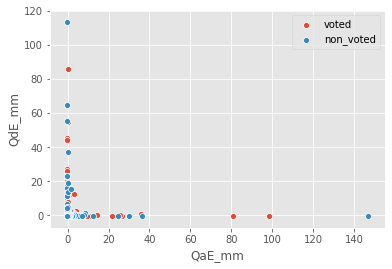

In [49]:
sns.scatterplot(
    vote['QaE_mm'],
    vote['QdE_mm'],
    label='voted')

sns.scatterplot(
    vote2['QaE_mm'],
    vote2['QdE_mm'],
    label='non_voted')

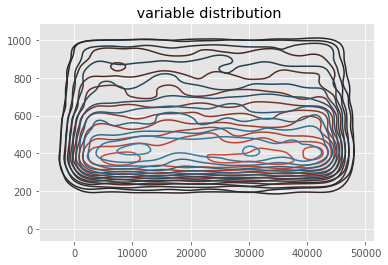

In [54]:
sns.kdeplot(vote2[vote2['QaE'] <= 1000],  label = 'non_voted', legend = True)
sns.kdeplot(vote[vote['QaE'] <= 1000], label = 'voted', legend = True)
plt.title(' variable distribution')
plt.show()

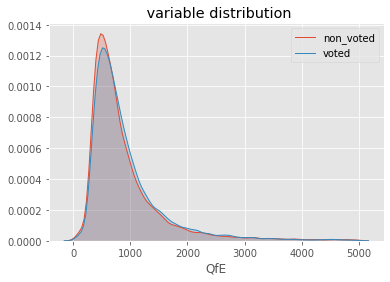

In [69]:
sns.distplot(vote2[vote2['QfE'] <= 5000]['QfE'], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 1}, label = 'non_voted')
sns.distplot(vote[vote['QfE'] <= 5000]['QfE'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, label = 'voted')
plt.title(' variable distribution')
plt.show()

In [34]:
vote[vote['QaE_mm'] <= 0.1]

,index,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,...,QlAnon_voted_value,QmAnon_voted_value,QnAnon_voted_value,QoAnon_voted_value,QpAnon_voted_value,QqAnon_voted_value,QrAnon_voted_value,QsAnon_voted_value,QtAnon_voted_value,QaE_mm
2,2,1623,1480,1021,3374,1333,531,1167,1016,2653,...,0.555001,0.498594,0.503868,0.513205,0.483372,0.454372,0.520620,0.491370,0.469089,0.002291
3,3,504,2311,992,3245,357,1519,159,2275,2809,...,0.529442,0.553238,0.503868,0.540300,0.561011,0.563144,0.520620,0.538763,0.597725,0.000686
4,4,927,707,556,1062,1014,628,991,1259,1153,...,0.555001,0.553238,0.546196,0.498814,0.561011,0.454372,0.527810,0.491370,0.519367,0.001293
6,6,1382,1473,1479,2403,616,549,390,1601,1312,...,0.529442,0.467587,0.503868,0.608421,0.514485,0.484087,0.520620,0.543511,0.469089,0.001945
7,7,384,908,870,1059,1266,483,592,2020,6022,...,0.555001,0.592483,0.578459,0.560556,0.603592,0.625057,0.527810,0.491370,0.469089,0.000514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,45523,365,1130,486,572,1010,570,1119,897,788,...,0.555001,0.592483,0.578459,0.498814,0.603592,0.625057,0.570839,0.538763,0.597725,0.000486
45525,45525,549,2383,1222,1672,1919,607,977,1501,2180,...,0.555001,0.592483,0.578459,0.608421,0.561011,0.625057,0.541311,0.538763,0.565911,0.000750
45529,45529,593,857,1047,1515,1690,1253,1094,1283,2209,...,0.555001,0.467587,0.503868,0.498814,0.483372,0.454372,0.527810,0.543511,0.469089,0.000813
45530,45530,747,1331,892,1281,1328,599,650,1429,1748,...,0.555001,0.553238,0.577689,0.498814,0.483372,0.484087,0.520620,0.538763,0.469089,0.001034


In [35]:
vote2[vote2['QaE_mm'] <= 0.1]

,index,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,...,QlAnon_voted_value,QmAnon_voted_value,QnAnon_voted_value,QoAnon_voted_value,QpAnon_voted_value,QqAnon_voted_value,QrAnon_voted_value,QsAnon_voted_value,QtAnon_voted_value,QaE_mm
0,0,363,1370,997,1024,1577,539,586,1095,1142,...,0.529442,0.498594,0.517668,0.513205,0.514485,0.578074,0.541311,0.520566,0.469089,0.000140
1,1,647,1313,3387,2969,4320,2190,826,4082,1867,...,0.529442,0.467587,0.517668,0.498814,0.603592,0.454372,0.572475,0.538763,0.469089,0.000258
5,5,834,1769,2105,1070,1930,1258,1451,1029,1633,...,0.512020,0.563659,0.577689,0.498814,0.483372,0.454372,0.572475,0.491370,0.519367,0.000335
10,10,1465,7581,1345,350,1747,1096,960,2785,7188,...,0.555001,0.592483,0.578459,0.513205,0.483372,0.563144,0.527810,0.538763,0.559764,0.000597
12,12,466,1650,655,1241,1339,515,936,1583,1654,...,0.555001,0.553238,0.517668,0.608421,0.561011,0.484087,0.520620,0.543511,0.597725,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45522,45522,1014,6022,3351,3788,2538,1646,893,3103,3792,...,0.555001,0.498594,0.546196,0.540300,0.514485,0.578074,0.520620,0.538763,0.597725,0.000410
45524,45524,254,839,557,768,876,106,740,650,1041,...,0.559207,0.498594,0.503868,0.540300,0.603592,0.578074,0.541311,0.538763,0.519367,0.000095
45526,45526,454,1007,758,1117,946,364,641,1261,1352,...,0.555001,0.553238,0.546196,0.498814,0.514485,0.484087,0.572475,0.491370,0.469089,0.000178
45527,45527,1050,619,328,285,602,267,315,483,1016,...,0.555001,0.553238,0.578459,0.513205,0.561011,0.578074,0.572475,0.599967,0.565911,0.000425


In [7]:
tr.groupby('voted')['QdE'].mean().reset_index()

,voted,QdE
0,1,1440.419793
1,2,1532.318499


In [25]:
vote[vote['QaE'] <= 60000 ]

,index,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,...,QkAnon_voted_value,QlAnon_voted_value,QmAnon_voted_value,QnAnon_voted_value,QoAnon_voted_value,QpAnon_voted_value,QqAnon_voted_value,QrAnon_voted_value,QsAnon_voted_value,QtAnon_voted_value
2,2,1623,1480,1021,3374,1333,531,1167,1016,2653,...,0.506491,0.555001,0.498594,0.503868,0.513205,0.483372,0.454372,0.520620,0.491370,0.469089
3,3,504,2311,992,3245,357,1519,159,2275,2809,...,0.591645,0.529442,0.553238,0.503868,0.540300,0.561011,0.563144,0.520620,0.538763,0.597725
4,4,927,707,556,1062,1014,628,991,1259,1153,...,0.506491,0.555001,0.553238,0.546196,0.498814,0.561011,0.454372,0.527810,0.491370,0.519367
6,6,1382,1473,1479,2403,616,549,390,1601,1312,...,0.541250,0.529442,0.467587,0.503868,0.608421,0.514485,0.484087,0.520620,0.543511,0.469089
7,7,384,908,870,1059,1266,483,592,2020,6022,...,0.541250,0.555001,0.592483,0.578459,0.560556,0.603592,0.625057,0.527810,0.491370,0.469089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,45523,365,1130,486,572,1010,570,1119,897,788,...,0.541250,0.555001,0.592483,0.578459,0.498814,0.603592,0.625057,0.570839,0.538763,0.597725
45525,45525,549,2383,1222,1672,1919,607,977,1501,2180,...,0.590401,0.555001,0.592483,0.578459,0.608421,0.561011,0.625057,0.541311,0.538763,0.565911
45529,45529,593,857,1047,1515,1690,1253,1094,1283,2209,...,0.506491,0.555001,0.467587,0.503868,0.498814,0.483372,0.454372,0.527810,0.543511,0.469089
45530,45530,747,1331,892,1281,1328,599,650,1429,1748,...,0.506491,0.555001,0.553238,0.577689,0.498814,0.483372,0.484087,0.520620,0.538763,0.469089


In [26]:
vote2[vote2['QaE'] <= 60000 ]

,index,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,...,QkAnon_voted_value,QlAnon_voted_value,QmAnon_voted_value,QnAnon_voted_value,QoAnon_voted_value,QpAnon_voted_value,QqAnon_voted_value,QrAnon_voted_value,QsAnon_voted_value,QtAnon_voted_value
0,0,363,1370,997,1024,1577,539,586,1095,1142,...,0.541250,0.529442,0.498594,0.517668,0.513205,0.514485,0.578074,0.541311,0.520566,0.469089
1,1,647,1313,3387,2969,4320,2190,826,4082,1867,...,0.506491,0.529442,0.467587,0.517668,0.498814,0.603592,0.454372,0.572475,0.538763,0.469089
5,5,834,1769,2105,1070,1930,1258,1451,1029,1633,...,0.506491,0.512020,0.563659,0.577689,0.498814,0.483372,0.454372,0.572475,0.491370,0.519367
10,10,1465,7581,1345,350,1747,1096,960,2785,7188,...,0.541250,0.555001,0.592483,0.578459,0.513205,0.483372,0.563144,0.527810,0.538763,0.559764
12,12,466,1650,655,1241,1339,515,936,1583,1654,...,0.506491,0.555001,0.553238,0.517668,0.608421,0.561011,0.484087,0.520620,0.543511,0.597725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45522,45522,1014,6022,3351,3788,2538,1646,893,3103,3792,...,0.591645,0.555001,0.498594,0.546196,0.540300,0.514485,0.578074,0.520620,0.538763,0.597725
45524,45524,254,839,557,768,876,106,740,650,1041,...,0.591645,0.559207,0.498594,0.503868,0.540300,0.603592,0.578074,0.541311,0.538763,0.519367
45526,45526,454,1007,758,1117,946,364,641,1261,1352,...,0.506491,0.555001,0.553238,0.546196,0.498814,0.514485,0.484087,0.572475,0.491370,0.469089
45527,45527,1050,619,328,285,602,267,315,483,1016,...,0.541250,0.555001,0.553238,0.578459,0.513205,0.561011,0.578074,0.572475,0.599967,0.565911
